<a href="https://colab.research.google.com/github/sanjay235/Generative-Adversarial-Networks/blob/master/Sketch2Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyunpack

  Created wheel for pyunpack: filename=pyunpack-0.1.2-cp36-none-any.whl size=5162 sha256=4d0b8d5aaca0cd5d089c08d8e111d4aaaa055210006e679743fae4ebc702a436
  Stored in directory: /root/.cache/pip/wheels/af/44/08/60613970881e542c0baad1f2dea5ed8e6716bc573f49197b7e
Successfully built pyunpack


In [0]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Dense, Input, BatchNormalization, ReLU, LeakyReLU, concatenate, Input
from tensorflow.keras.activations import tanh, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import tensorflow as tf

import tensorflow.keras.backend as K

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pyunpack import Archive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
Archive('drive/My Drive/Sketch2Image/AnimeData.zip').extractall('.')

(511, 511)


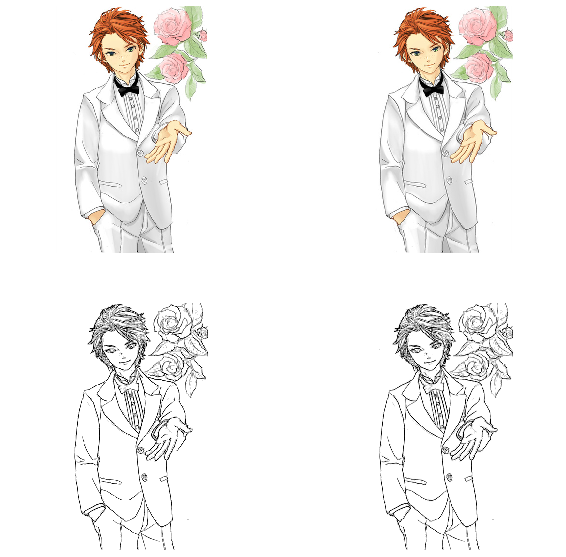

In [32]:
img = Image.open('Images/235.png').convert('RGB')
img2 = Image.open('Sketches/235.png').convert('RGB')

print(img.size)

f,a = plt.subplots(2, 2, figsize=(10,10))
a = a.flatten()

for ax, i in zip(a, [img, img.resize((512, 512), Image.LANCZOS), img2, img2.resize((512, 512), Image.LANCZOS)]):
  ax.imshow(i)
  ax.axis('off')

plt.subplots_adjust(wspace=.2, hspace=.2)
plt.show()

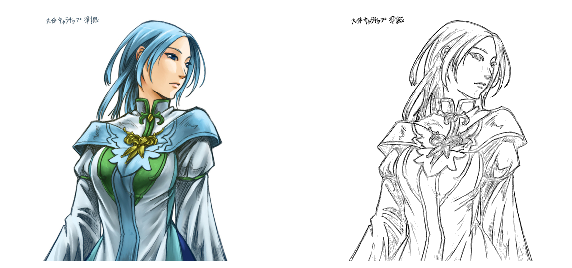

In [0]:
img = Image.open('/content/1213037.png').convert('RGB')

# print(img.size)

f,a = plt.subplots(1, 2, figsize=(10,5))
a = a.flatten()

for ax, i in zip(a, [np.array(img)[:,:512], np.array(img)[:,512:]]):
  # i = np.array(i)
  # i[i==[0,0,0]]=255
  # print(i[0])
  # print(i.shape)
  ax.imshow(i)
  ax.axis('off')

plt.show()

In [0]:
def convBlock(inp, n_filters, filter_size=4, stride=2, activation=True, BN=True, padding='same'):

  y = Conv2D(n_filters, filter_size, stride, padding)(inp)

  if BN:
    y = BatchNormalization()(y)

  if activation:
    y = LeakyReLU(.2)(y)

  print(y.shape)
  return y

def convTransBlock(inp, n_filters, filter_size=4, stride=2, convOut=None, activation=True, BN=True, padding='same'):

  y = Conv2DTranspose(n_filters, filter_size, stride, padding)(concatenate([inp, convOut]) if convOut is not None else inp)

  if BN:
    y = BatchNormalization()(y)

  if activation:
    y = LeakyReLU(.2)(y)

  print(y.shape)
  return y

In [0]:
def generator(inp_shape=(512, 512, 3)):
  n_filters = 32
  
  inp = Input(inp_shape)

  print('Encoder:')
  conv1 = convBlock(inp, n_filters,)
  conv2 = convBlock(conv1, n_filters*2,)
  conv3 = convBlock(conv2, n_filters*4,)
  conv4 = convBlock(conv3, n_filters*8,)
  conv5 = convBlock(conv4, n_filters*8,)
  conv6 = convBlock(conv5, n_filters*8,)
  conv7 = convBlock(conv6, n_filters*8,)
  conv8 = convBlock(conv7, n_filters*8,) # 2x2x512

  print('Decoder:')
  deconv1 = convTransBlock(conv8, n_filters*8)
  deconv2 = convTransBlock(deconv1, n_filters*8, convOut=conv7)
  deconv3 = convTransBlock(deconv2, n_filters*8, convOut=conv6)
  deconv4 = convTransBlock(deconv3, n_filters*8, convOut=conv5)
  deconv5 = convTransBlock(deconv4, n_filters*4, convOut=conv4)
  deconv6 = convTransBlock(deconv5, n_filters*2, convOut=conv3)
  deconv7 = convTransBlock(deconv6, n_filters, convOut=conv2)
  deconv8 = convTransBlock(deconv7, 3, convOut=conv1, activation=False, BN=False)

  outp = tanh(deconv8)

  model = Model(inputs=inp, outputs=outp)

  return model

In [29]:
m = generator()

Encoder:
(?, 256, 256, 32)
(?, 128, 128, 64)
(?, 64, 64, 128)
(?, 32, 32, 256)
(?, 16, 16, 256)
(?, 8, 8, 256)
(?, 4, 4, 256)
(?, 2, 2, 256)
Decoder:
(?, 4, 4, 256)
(?, 8, 8, 256)
(?, 16, 16, 256)
(?, 32, 32, 256)
(?, 64, 64, 128)
(?, 128, 128, 64)
(?, 256, 256, 32)
(?, 512, 512, 3)


In [0]:
def discriminator(inp_shape=(512, 512, 3), target_shape=(512, 512, 3)):
  n_filters = 32
  
  inp1 = Input(inp_shape) # sketch input
  inp2 = Input(target_shape) # colored input

  inp = concatenate([inp1, inp2])

  conv1 = convBlock(inp, n_filters, BN=False)
  conv2 = convBlock(conv1, n_filters*2)
  conv3 = convBlock(conv2, n_filters*4)
  conv4 = convBlock(conv3, n_filters*8)
  conv5 = convBlock(conv4, n_filters*8, filter_size=2, stride=1, padding='valid')
  conv6 = convBlock(conv5, n_filters=1, filter_size=2, stride=1, activation=False, BN=False, padding='valid')

  outp = sigmoid(conv6)

  model = Model(inputs=[inp1, inp2], outputs=outp)

  opt = Adam(lr=.0002, beta_1=.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  
  return model

In [55]:
m = discriminator()

(?, 256, 256, 32)
(?, 128, 128, 64)
(?, 64, 64, 128)
(?, 32, 32, 256)
(?, 31, 31, 256)
(?, 30, 30, 1)


In [0]:
K.abs?

In [0]:
def KL_loss(y_true, y_pred):
    
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss

def custom_generator_loss(y_true, y_pred):

    return K.binary_crossentropy(y_true, y_pred)

In [0]:
# https://stackoverflow.com/a/45963039/9079093

def featureLevel_loss():

  def finalLoss(y_true, y_pred):
    return K.mean(K.abs( y - g ))
  
  return finalLoss

def totalVariation_loss(g):

  def finalLoss(y_true, y_pred):
    return K.mean(K.abs( K.sqrt(K.square(g[:, 1:, :, :] - g[:, :-1, :, :]) + K.square(g[:, :, 1:, :] - g[:, :, :-1, :])) ))
  
  return finalLoss

def pixelLevel_loss(y, g):
  
  def finalLoss(y_true, y_pred):
    return K.mean(K.abs( y - g ))
  
  return finalLoss

In [0]:
def define_gan(g_model, d_model, inp_shape=(512, 512, 3)):
	
	d_model.trainable = False
	
  # Generator
  sketch_inp = Input(inp_shape)
  gen_color_output = g_model([sketch_inp])
	
	# Discriminator
  disc_outputs = d_model([sketch_inp, gen_color_output])
  
  color_inp = Input(inp_shape)
	
  pixelLevelLoss = pixelLevel_loss(color_inp, gen_outputs)
  totalVariationLoss = totalVariation_loss(gen_outputs)
  
  opt = Adam(lr=.0002, beta_1=.5)
	model.compile(loss=['binary_crossentropy', pixelLevelLoss, ], optimizer=opt)
	
  return model